## Загрузка датасета

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
%cd /content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset

/content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset


In [81]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd


In [82]:
dataset = pd.read_csv("syscalls_dataset.csv")

In [83]:
dataset

,last syscalls,syscall
0,"kwin_x11syscallreadsyscall(5, ""\1\0\0\0\0\0\0\...","kwin_x11syscallwritevsyscall(3, [{iov_base=""\2..."
1,_opt_google_chrome_chromesyscallepoll_waitsysc...,_opt_google_chrome_chromesyscallsendtosyscall(...
2,"_usr_lib_xorg_Xorgsyscallwritevsyscall(103, [{...","_usr_lib_xorg_Xorgsyscallwritevsyscall(103, [{..."
3,"_usr_lib_xorg_Xorgsyscallioctlsyscall(18, DRM_...","_usr_lib_xorg_Xorgsyscallreadsyscall(18, ""\2\0..."
4,_opt_google_chrome_chromesyscallepoll_waitsysc...,_opt_google_chrome_chromesyscallepoll_waitsysc...
...,...,...
366027,"chromesyscallepoll_waitsyscall(29, [{events=EP...","chromesyscallsendtosyscall(106, ""\10\0\0\0h\0\..."
366028,"at-spi2-registrsyscallrecvmsgsyscall(5, {msg_n...","at-spi2-registrsyscallrecvmsgsyscall(5, {msg_n..."
366029,"Xorgsyscallrecvmsgsyscall(53, {msg_name=NULL, ...","Xorgsyscallioctlsyscall(20, DRM_IOCTL_I915_GEM..."
366030,"Xorgsyscallrecvmsgsyscall(86, {msg_namelen=0},...","Xorgsyscallwritevsyscall(86, [{iov_base=""\1\0v..."


In [84]:
from sklearn.utils import shuffle

dataset = shuffle(dataset)

In [85]:
dataset

,last syscalls,syscall
206365,"kwin_x11syscallpollsyscall([{fd=3, events=POLL...","kwin_x11syscallpollsyscall([{fd=3, events=POLL..."
244775,"kwin_x11syscallpollsyscall([{fd=3, events=POLL...","kwin_x11syscallrecvmsgsyscall(3, {msg_name=NUL..."
141127,"mongodsyscallfutexsyscall(0x55833622d378, FUTE...","mongodsyscallgetrusagesyscall(RUSAGE_SELF, {ru..."
172554,"javasyscallfutexsyscall(0x7f927424927c, FUTEX_...","javasyscallfutexsyscall(0x7f92741c4fa8, FUTEX_..."
257216,_usr_lib_xorg_Xorgsyscallsetitimersyscall(ITIM...,"_usr_lib_xorg_Xorgsyscallepoll_waitsyscall(3, ..."
...,...,...
176689,plasmashellsyscallmadvisesyscall(0x7f011c1b000...,plasmashellsyscallmadvisesyscall(0x7f01197f600...
60261,kded5syscallclosesyscall(95)syscall0last_n_sys...,"kded5syscallioctlsyscall(95, SIOCGIFHWADDR, {i..."
146000,"_usr_bin_kwin_x11syscallppollsyscall([{fd=15, ...","_usr_bin_kwin_x11syscallioctlsyscall(11, DRM_I..."
203180,_usr_sbin_acpidsyscallrt_sigprocmasksyscall(SI...,_usr_sbin_acpidsyscallrt_sigprocmasksyscall(SI...


## Выбор девайса

In [86]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [87]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import torch
from torch.nn import Embedding, Linear, LSTM, Module, Sigmoid
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import re
import time

## Разбиение данных на токены

In [88]:
import re

def tokenizer(syscalls):
    syscalls = syscalls.split(sep='last_n_syscalls')
    tokens = []
    for syscall in syscalls:
        str = syscall.split(sep='syscall')
        str = [s if len(s) > 0 else '<pad>' for s in str]
        tokens.extend(['command', str[0], 'syscallname', str[1], 'syscallargs', str[2], 'syscallres', str[3], 'syscallend'])

    return tokens

## Преобразование токены в коды

In [89]:
from collections import Counter

In [90]:
def token_to_sequence(tokens, token2index):
    seq = []
    for token in tokens:
        index = token2index.get(token, len(token2index) - 1) # len(token2index) - 1 означает неизвестное слово
        seq.append(index)

    return seq

## Класс данных системных вызовов для обучения

In [91]:
class SyscallDataset(Dataset):
    def __init__(self, dataset, token_size):
        self.dataset = dataset

        # Разбиваем системные вызовы на токены
        self.last_syscalls_tokens = [tokenizer(self.dataset.iloc[i]['last syscalls']) for i in range(len(self.dataset))]
        self.syscall_tokens = [tokenizer(self.dataset.iloc[i]['syscall']) for i in range(len(self.dataset))]

        # Все токены встретившихся системных вызовов
        syscalls_names = [last_syscall[j+3] for last_syscall in self.last_syscalls_tokens
                              for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        syscalls_names.extend([syscall[3] for syscall in self.syscall_tokens])

        # Все токены встретившихся команд
        command_names = [last_syscall[j+1] for last_syscall in self.last_syscalls_tokens
                              for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        command_names.extend([syscall[1] for syscall in self.syscall_tokens])


        # Индексируем встречающиеся названия системных вызовов по их встречаемости
        tokens_counter = Counter(syscalls_names)

        most_common_token2index = {
            token[0]: i
            for i, token in enumerate(tokens_counter.most_common())
        }

        # Все названия встретившихся системных вызовов
        self.syscalls_name = list(tokens_counter.keys())


        # Добавление токенов названий команд для индексации
        tokens_counter = Counter(command_names)

        most_common_token2index.update({
            token[0]: i + len(self.syscalls_name)
            for i, token in enumerate(tokens_counter.most_common())
        })

        # Все названия встретившихся команд
        self.сommands_name = list(tokens_counter.keys())


        # Добавление оставшихся токенов для индексации
        tokens_counter = Counter()

        for syscalls_token in self.last_syscalls_tokens:
            for token in syscalls_token:
                if token not in self.syscalls_name and token not in self.сommands_name:
                    tokens_counter.update({token: 1})

        most_common_token2index.update({
            token[0]: i + len(self.syscalls_name) + len(self.сommands_name)
            for i, token in enumerate(tokens_counter.most_common()[:(token_size - 2 - len(self.syscalls_name) - len(self.сommands_name))])
        })


        # Словарь, отображающий токены в коды
        self.token2index = dict()
        # Словарь, отображающий коды в токены
        self.index2token = dict()


        self.token2index.update(most_common_token2index)
        self.token2index.update({"<pad>": len(self.token2index), "<unk>": len(self.token2index) + 1})

        self.index2token = {v: k for k, v in self.token2index.items()}

        self.token_size = min(len(self.index2token), token_size)

        self.vocabulary = [self.index2token[i] for i in range(len(self.syscalls_name))]


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
        X = torch.LongTensor(
            token_to_sequence(self.last_syscalls_tokens[ix], self.token2index)
        )

        y = token_to_sequence(self.syscall_tokens[ix], self.token2index)

        return X, y[3]


## Класс нейронной сети системных вызовов

In [92]:
class SyscallNetwork(Module):
    def __init__(
        self,
        token_size,
        syscalls_name_len,
        embedding_dim=2,
        hidden_dim_2=32,
        max_norm=2,
    ):
        super().__init__()

        self.embedding = Embedding(
                token_size,
                embedding_dim,
                padding_idx=0,
                norm_type=2,
                max_norm=max_norm,
        )

        self.linear_1 = Linear(45 * embedding_dim, hidden_dim_2)
        self.sigmoid = Sigmoid()
        self.linear_2 = Linear(hidden_dim_2, syscalls_name_len)



    def forward(self, x):
        emb = self.embedding(x)  # (n_samples, 45, 2)
        emb = emb.reshape(x.shape[0], -1)

        x = self.linear_1(emb)
        x = self.sigmoid(x)
        x = self.linear_2(x)

        return x


def compute_loss_accuracy_perfomance(loss, net, dataloader):
    net.eval()
    all_losses = []
    all_accuracy = []
    all_perfomance = 0

    for X_batch, y_batch in dataloader:
        time_start = time.time_ns()
        pred = net(X_batch)
        time_end = time.time_ns()
        all_perfomance += (time_end - time_start)

        all_losses.append(loss(pred, y_batch).item())

        pred = pred.argmax(dim=1)
        all_accuracy.append((pred == y_batch).float().mean())

    return np.mean(all_losses), np.mean(all_accuracy), (all_perfomance // len(dataloader.dataset))


#### Задание гиперпараметров

In [122]:
token_size = 5000 # максимальное количество токенов
embedding_dim = 4
hidden_dim_2 = 16
max_norm = 2

n_epochs = 200
train_split = 0.7
val_split = 0.1
batch_size = 128

#### Функция потерь

In [94]:
loss_f = torch.nn.CrossEntropyLoss()

## Создание тренировочного и валидационного датасета

In [95]:
syscalldataset = SyscallDataset(dataset, token_size)


n_samples = len(dataset)
train_ix = int(n_samples * train_split)
val_ix = int(n_samples * val_split) + train_ix

train_indices, val_indices, test_indices = np.arange(train_ix), np.arange(train_ix, val_ix), np.arange(val_ix, n_samples)

train_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(train_indices),
        batch_size=batch_size
)
val_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(val_indices),
        batch_size=batch_size
)
test_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(test_indices),
        batch_size=batch_size
)

## Создание нейронной сети и оптимайзера


In [123]:
net = SyscallNetwork(
        syscalldataset.token_size,
        len(syscalldataset.syscalls_name),
        hidden_dim_2=hidden_dim_2,
        embedding_dim=embedding_dim,
        max_norm=max_norm,
)

optimizer = torch.optim.Adam(
        net.parameters(),
        lr=1e-2,
)


## Обучение нейронной сети и сохранение лучшей модели

In [124]:
emb_history = []
val_accuracy_history = []
val_loss_history = []
val_perfomance_history = []
train_loss_history = []
best_val_acc = 0.0

for epoch in range(n_epochs):
    net.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        pred = net(X_batch)
        loss = loss_f(pred, y_batch)
        loss.backward()

        optimizer.step()


    if epoch % 1 == 0 or epoch == n_epochs:
        train_loss, _, _= compute_loss_accuracy_perfomance(loss_f, net, train_dataloader)
        val_loss, val_acc, val_perf = compute_loss_accuracy_perfomance(loss_f, net, val_dataloader)
        print(f"Epoch: {epoch}, train loss: {train_loss=:.3f}, validation loss {val_loss=:.3f}")
        print(f'Perfomance {val_perf}')
        print(f'Accuracy: {val_acc}')
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_acc)
        val_perfomance_history.append(val_perf)

        if (val_acc > best_val_acc):
            best_val_acc = val_acc
            torch.save(net.state_dict(), 'best-model-syscall-prediction.pt')


    # Prepare DataFrame

    weights = net.embedding.weight.detach().clone().numpy()[:len(syscalldataset.vocabulary)]

    df = pd.DataFrame(weights, columns=[f"dim_{i}" for i in range(embedding_dim)])
    df["epoch"] = epoch
    df["token"] = syscalldataset.vocabulary


    emb_history.append(df)

final_df = pd.concat(emb_history)
final_df.to_csv("emb.csv", index=False)

100%|██████████| 2002/2002 [00:22<00:00, 89.86it/s]


Epoch: 0, train loss: train_loss=0.582, validation loss val_loss=0.617
Perfomance 1732
Accuracy: 0.8262374997138977


100%|██████████| 2002/2002 [00:24<00:00, 80.90it/s]


Epoch: 1, train loss: train_loss=0.508, validation loss val_loss=0.558
Perfomance 1505
Accuracy: 0.8419532775878906


100%|██████████| 2002/2002 [00:23<00:00, 86.17it/s]


Epoch: 2, train loss: train_loss=0.482, validation loss val_loss=0.542
Perfomance 1435
Accuracy: 0.8451515436172485


100%|██████████| 2002/2002 [00:24<00:00, 80.09it/s]


Epoch: 3, train loss: train_loss=0.467, validation loss val_loss=0.529
Perfomance 1451
Accuracy: 0.8484067320823669


100%|██████████| 2002/2002 [00:23<00:00, 85.56it/s]


Epoch: 4, train loss: train_loss=0.459, validation loss val_loss=0.531
Perfomance 1424
Accuracy: 0.8502301573753357


100%|██████████| 2002/2002 [00:25<00:00, 77.36it/s]


Epoch: 5, train loss: train_loss=0.453, validation loss val_loss=0.528
Perfomance 1461
Accuracy: 0.8493560552597046


100%|██████████| 2002/2002 [00:23<00:00, 85.53it/s]


Epoch: 6, train loss: train_loss=0.446, validation loss val_loss=0.523
Perfomance 1447
Accuracy: 0.8532110452651978


100%|██████████| 2002/2002 [00:23<00:00, 85.56it/s] 


Epoch: 7, train loss: train_loss=0.446, validation loss val_loss=0.527
Perfomance 1418
Accuracy: 0.8505579829216003


100%|██████████| 2002/2002 [00:24<00:00, 80.61it/s] 


Epoch: 8, train loss: train_loss=0.440, validation loss val_loss=0.526
Perfomance 1595
Accuracy: 0.8527422547340393


100%|██████████| 2002/2002 [00:22<00:00, 87.47it/s] 


Epoch: 9, train loss: train_loss=0.440, validation loss val_loss=0.527
Perfomance 1424
Accuracy: 0.8502017855644226


100%|██████████| 2002/2002 [00:24<00:00, 81.86it/s] 


Epoch: 10, train loss: train_loss=0.437, validation loss val_loss=0.528
Perfomance 1906
Accuracy: 0.8521959185600281


100%|██████████| 2002/2002 [00:22<00:00, 89.57it/s] 


Epoch: 11, train loss: train_loss=0.439, validation loss val_loss=0.528
Perfomance 1648
Accuracy: 0.8532383441925049


100%|██████████| 2002/2002 [00:24<00:00, 81.05it/s]


Epoch: 12, train loss: train_loss=0.432, validation loss val_loss=0.526
Perfomance 2176
Accuracy: 0.855637788772583


100%|██████████| 2002/2002 [00:22<00:00, 88.75it/s]


Epoch: 13, train loss: train_loss=0.433, validation loss val_loss=0.524
Perfomance 1474
Accuracy: 0.8554420471191406


100%|██████████| 2002/2002 [00:23<00:00, 83.98it/s]


Epoch: 14, train loss: train_loss=0.430, validation loss val_loss=0.524
Perfomance 1448
Accuracy: 0.8536196351051331


100%|██████████| 2002/2002 [00:26<00:00, 76.75it/s]


Epoch: 15, train loss: train_loss=0.430, validation loss val_loss=0.527
Perfomance 1479
Accuracy: 0.8549308776855469


100%|██████████| 2002/2002 [00:24<00:00, 80.43it/s]


Epoch: 16, train loss: train_loss=0.424, validation loss val_loss=0.521
Perfomance 1443
Accuracy: 0.8566473722457886


100%|██████████| 2002/2002 [00:26<00:00, 75.97it/s]


Epoch: 17, train loss: train_loss=0.426, validation loss val_loss=0.525
Perfomance 1511
Accuracy: 0.8551165461540222


100%|██████████| 2002/2002 [00:24<00:00, 82.85it/s]


Epoch: 18, train loss: train_loss=0.424, validation loss val_loss=0.525
Perfomance 1776
Accuracy: 0.8576273918151855


100%|██████████| 2002/2002 [00:25<00:00, 78.26it/s]


Epoch: 19, train loss: train_loss=0.430, validation loss val_loss=0.532
Perfomance 1621
Accuracy: 0.8515949249267578


100%|██████████| 2002/2002 [00:23<00:00, 85.97it/s]


Epoch: 20, train loss: train_loss=0.432, validation loss val_loss=0.534
Perfomance 1411
Accuracy: 0.8544129729270935


100%|██████████| 2002/2002 [00:24<00:00, 82.15it/s]


Epoch: 21, train loss: train_loss=0.430, validation loss val_loss=0.531
Perfomance 1524
Accuracy: 0.8527377247810364


100%|██████████| 2002/2002 [00:26<00:00, 74.23it/s]


Epoch: 22, train loss: train_loss=0.431, validation loss val_loss=0.531
Perfomance 1463
Accuracy: 0.8516702055931091


100%|██████████| 2002/2002 [00:24<00:00, 80.22it/s]


Epoch: 23, train loss: train_loss=0.424, validation loss val_loss=0.530
Perfomance 1650
Accuracy: 0.8555000424385071


100%|██████████| 2002/2002 [00:26<00:00, 75.60it/s]


Epoch: 24, train loss: train_loss=0.423, validation loss val_loss=0.529
Perfomance 1522
Accuracy: 0.8543243408203125


100%|██████████| 2002/2002 [00:24<00:00, 81.42it/s]


Epoch: 25, train loss: train_loss=0.430, validation loss val_loss=0.533
Perfomance 1443
Accuracy: 0.8541103005409241


100%|██████████| 2002/2002 [00:27<00:00, 74.02it/s]


Epoch: 26, train loss: train_loss=0.426, validation loss val_loss=0.533
Perfomance 1449
Accuracy: 0.8538950681686401


100%|██████████| 2002/2002 [00:24<00:00, 80.90it/s]


Epoch: 27, train loss: train_loss=0.423, validation loss val_loss=0.532
Perfomance 2012
Accuracy: 0.8539451956748962


100%|██████████| 2002/2002 [00:23<00:00, 84.39it/s]


Epoch: 28, train loss: train_loss=0.421, validation loss val_loss=0.528
Perfomance 2064
Accuracy: 0.8564605712890625


100%|██████████| 2002/2002 [00:24<00:00, 80.74it/s]


Epoch: 29, train loss: train_loss=0.423, validation loss val_loss=0.530
Perfomance 1564
Accuracy: 0.854223906993866


100%|██████████| 2002/2002 [00:24<00:00, 80.32it/s]


Epoch: 30, train loss: train_loss=0.428, validation loss val_loss=0.539
Perfomance 1421
Accuracy: 0.8498193621635437


100%|██████████| 2002/2002 [00:26<00:00, 76.76it/s]


Epoch: 31, train loss: train_loss=0.425, validation loss val_loss=0.537
Perfomance 1444
Accuracy: 0.8538588881492615


100%|██████████| 2002/2002 [00:24<00:00, 81.25it/s]


Epoch: 32, train loss: train_loss=0.424, validation loss val_loss=0.536
Perfomance 1683
Accuracy: 0.8552290797233582


100%|██████████| 2002/2002 [00:24<00:00, 81.17it/s]


Epoch: 33, train loss: train_loss=0.423, validation loss val_loss=0.535
Perfomance 1473
Accuracy: 0.8516278266906738


100%|██████████| 2002/2002 [00:25<00:00, 77.60it/s]


Epoch: 34, train loss: train_loss=0.425, validation loss val_loss=0.535
Perfomance 1491
Accuracy: 0.8526111841201782


100%|██████████| 2002/2002 [00:25<00:00, 77.04it/s]


Epoch: 35, train loss: train_loss=0.426, validation loss val_loss=0.541
Perfomance 2198
Accuracy: 0.8546861410140991


100%|██████████| 2002/2002 [00:27<00:00, 71.67it/s]


Epoch: 36, train loss: train_loss=0.421, validation loss val_loss=0.538
Perfomance 1481
Accuracy: 0.8545277714729309


100%|██████████| 2002/2002 [00:25<00:00, 78.97it/s]


Epoch: 37, train loss: train_loss=0.417, validation loss val_loss=0.531
Perfomance 1510
Accuracy: 0.8541933298110962


100%|██████████| 2002/2002 [00:27<00:00, 72.04it/s]


Epoch: 38, train loss: train_loss=0.427, validation loss val_loss=0.539
Perfomance 2162
Accuracy: 0.8553438782691956


100%|██████████| 2002/2002 [00:23<00:00, 84.01it/s]


Epoch: 39, train loss: train_loss=0.428, validation loss val_loss=0.545
Perfomance 1437
Accuracy: 0.8530449271202087


100%|██████████| 2002/2002 [00:24<00:00, 82.04it/s]


Epoch: 40, train loss: train_loss=0.432, validation loss val_loss=0.546
Perfomance 1490
Accuracy: 0.853203296661377


100%|██████████| 2002/2002 [00:24<00:00, 80.93it/s]


Epoch: 41, train loss: train_loss=0.423, validation loss val_loss=0.538
Perfomance 1431
Accuracy: 0.8548489212989807


100%|██████████| 2002/2002 [00:24<00:00, 82.30it/s]


Epoch: 42, train loss: train_loss=0.424, validation loss val_loss=0.542
Perfomance 1425
Accuracy: 0.8521913886070251


100%|██████████| 2002/2002 [00:26<00:00, 74.99it/s]


Epoch: 43, train loss: train_loss=0.421, validation loss val_loss=0.535
Perfomance 2081
Accuracy: 0.8548533916473389


100%|██████████| 2002/2002 [00:23<00:00, 85.95it/s]


Epoch: 44, train loss: train_loss=0.423, validation loss val_loss=0.539
Perfomance 1478
Accuracy: 0.8543571829795837


100%|██████████| 2002/2002 [00:26<00:00, 74.32it/s]


Epoch: 45, train loss: train_loss=0.423, validation loss val_loss=0.538
Perfomance 1424
Accuracy: 0.8537311553955078


100%|██████████| 2002/2002 [00:24<00:00, 82.41it/s]


Epoch: 46, train loss: train_loss=0.425, validation loss val_loss=0.541
Perfomance 1438
Accuracy: 0.8545178174972534


100%|██████████| 2002/2002 [00:26<00:00, 76.57it/s]


Epoch: 47, train loss: train_loss=0.424, validation loss val_loss=0.542
Perfomance 1438
Accuracy: 0.8533376455307007


100%|██████████| 2002/2002 [00:24<00:00, 82.74it/s]


Epoch: 48, train loss: train_loss=0.422, validation loss val_loss=0.546
Perfomance 1931
Accuracy: 0.8535835146903992


100%|██████████| 2002/2002 [00:23<00:00, 85.57it/s]


Epoch: 49, train loss: train_loss=0.420, validation loss val_loss=0.545
Perfomance 2194
Accuracy: 0.8536809682846069


100%|██████████| 2002/2002 [00:25<00:00, 77.88it/s]


Epoch: 50, train loss: train_loss=0.423, validation loss val_loss=0.540
Perfomance 1432
Accuracy: 0.8536481261253357


100%|██████████| 2002/2002 [00:23<00:00, 84.56it/s]


Epoch: 51, train loss: train_loss=0.430, validation loss val_loss=0.550
Perfomance 1392
Accuracy: 0.8500323295593262


100%|██████████| 2002/2002 [00:26<00:00, 75.62it/s]


Epoch: 52, train loss: train_loss=0.420, validation loss val_loss=0.541
Perfomance 1402
Accuracy: 0.8538053035736084


100%|██████████| 2002/2002 [00:23<00:00, 83.46it/s]


Epoch: 53, train loss: train_loss=0.423, validation loss val_loss=0.541
Perfomance 1383
Accuracy: 0.8524144291877747


100%|██████████| 2002/2002 [00:26<00:00, 76.44it/s]


Epoch: 54, train loss: train_loss=0.423, validation loss val_loss=0.542
Perfomance 1488
Accuracy: 0.8516506552696228


100%|██████████| 2002/2002 [00:24<00:00, 83.04it/s]


Epoch: 55, train loss: train_loss=0.427, validation loss val_loss=0.548
Perfomance 2195
Accuracy: 0.8544085025787354


100%|██████████| 2002/2002 [00:22<00:00, 87.12it/s]


Epoch: 56, train loss: train_loss=0.423, validation loss val_loss=0.543
Perfomance 1985
Accuracy: 0.8546432852745056


100%|██████████| 2002/2002 [00:26<00:00, 75.68it/s]


Epoch: 57, train loss: train_loss=0.422, validation loss val_loss=0.547
Perfomance 1453
Accuracy: 0.8546521663665771


100%|██████████| 2002/2002 [00:23<00:00, 84.08it/s]


Epoch: 58, train loss: train_loss=0.424, validation loss val_loss=0.548
Perfomance 1418
Accuracy: 0.852164089679718


100%|██████████| 2002/2002 [00:26<00:00, 76.51it/s]


Epoch: 59, train loss: train_loss=0.423, validation loss val_loss=0.543
Perfomance 1413
Accuracy: 0.8544982671737671


100%|██████████| 2002/2002 [00:24<00:00, 83.29it/s]


Epoch: 60, train loss: train_loss=0.421, validation loss val_loss=0.548
Perfomance 1422
Accuracy: 0.8530789017677307


100%|██████████| 2002/2002 [00:26<00:00, 76.41it/s]


Epoch: 61, train loss: train_loss=0.417, validation loss val_loss=0.541
Perfomance 1509
Accuracy: 0.8558902144432068


100%|██████████| 2002/2002 [00:24<00:00, 81.09it/s]


Epoch: 62, train loss: train_loss=0.421, validation loss val_loss=0.547
Perfomance 1885
Accuracy: 0.8542457222938538


100%|██████████| 2002/2002 [00:23<00:00, 83.58it/s]


Epoch: 63, train loss: train_loss=0.426, validation loss val_loss=0.551
Perfomance 1468
Accuracy: 0.8525772094726562


100%|██████████| 2002/2002 [00:23<00:00, 84.35it/s]


Epoch: 64, train loss: train_loss=0.422, validation loss val_loss=0.545
Perfomance 1441
Accuracy: 0.8534741997718811


100%|██████████| 2002/2002 [00:24<00:00, 82.81it/s]


Epoch: 65, train loss: train_loss=0.421, validation loss val_loss=0.547
Perfomance 1426
Accuracy: 0.8523859977722168


100%|██████████| 2002/2002 [00:25<00:00, 77.32it/s]


Epoch: 66, train loss: train_loss=0.435, validation loss val_loss=0.555
Perfomance 1510
Accuracy: 0.8513513207435608


100%|██████████| 2002/2002 [00:23<00:00, 84.45it/s]


Epoch: 67, train loss: train_loss=0.419, validation loss val_loss=0.545
Perfomance 1517
Accuracy: 0.8544085025787354


100%|██████████| 2002/2002 [00:23<00:00, 85.61it/s] 


Epoch: 68, train loss: train_loss=0.425, validation loss val_loss=0.550
Perfomance 1418
Accuracy: 0.8522264957427979


100%|██████████| 2002/2002 [00:23<00:00, 85.01it/s]


Epoch: 69, train loss: train_loss=0.424, validation loss val_loss=0.550
Perfomance 2115
Accuracy: 0.8525204062461853


100%|██████████| 2002/2002 [00:22<00:00, 90.30it/s]


Epoch: 70, train loss: train_loss=0.423, validation loss val_loss=0.550
Perfomance 2359
Accuracy: 0.8567906022071838


100%|██████████| 2002/2002 [00:24<00:00, 80.14it/s]


Epoch: 71, train loss: train_loss=0.421, validation loss val_loss=0.546
Perfomance 1410
Accuracy: 0.853634774684906


100%|██████████| 2002/2002 [00:22<00:00, 89.20it/s]


Epoch: 72, train loss: train_loss=0.421, validation loss val_loss=0.554
Perfomance 1445
Accuracy: 0.8534524440765381


100%|██████████| 2002/2002 [00:25<00:00, 79.01it/s]


Epoch: 73, train loss: train_loss=0.422, validation loss val_loss=0.551
Perfomance 1384
Accuracy: 0.8499013185501099


100%|██████████| 2002/2002 [00:22<00:00, 87.49it/s]


Epoch: 74, train loss: train_loss=0.420, validation loss val_loss=0.550
Perfomance 1385
Accuracy: 0.8511656522750854


100%|██████████| 2002/2002 [00:25<00:00, 77.54it/s]


Epoch: 75, train loss: train_loss=0.425, validation loss val_loss=0.553
Perfomance 1404
Accuracy: 0.8514639139175415


100%|██████████| 2002/2002 [00:23<00:00, 84.82it/s]


Epoch: 76, train loss: train_loss=0.422, validation loss val_loss=0.553
Perfomance 1400
Accuracy: 0.8535422086715698


100%|██████████| 2002/2002 [00:23<00:00, 83.94it/s]


Epoch: 77, train loss: train_loss=0.424, validation loss val_loss=0.551
Perfomance 1333
Accuracy: 0.8529061079025269


100%|██████████| 2002/2002 [00:25<00:00, 77.21it/s]


Epoch: 78, train loss: train_loss=0.425, validation loss val_loss=0.549
Perfomance 1414
Accuracy: 0.8544369339942932


100%|██████████| 2002/2002 [00:24<00:00, 83.14it/s]


Epoch: 79, train loss: train_loss=0.421, validation loss val_loss=0.554
Perfomance 1394
Accuracy: 0.8548739552497864


100%|██████████| 2002/2002 [00:26<00:00, 76.63it/s]


Epoch: 80, train loss: train_loss=0.426, validation loss val_loss=0.559
Perfomance 2034
Accuracy: 0.8532951474189758


100%|██████████| 2002/2002 [00:22<00:00, 90.76it/s]


Epoch: 81, train loss: train_loss=0.422, validation loss val_loss=0.550
Perfomance 2179
Accuracy: 0.8541910648345947


100%|██████████| 2002/2002 [00:25<00:00, 79.45it/s]


Epoch: 82, train loss: train_loss=0.424, validation loss val_loss=0.549
Perfomance 1451
Accuracy: 0.8527171611785889


100%|██████████| 2002/2002 [00:23<00:00, 84.73it/s]


Epoch: 83, train loss: train_loss=0.425, validation loss val_loss=0.555
Perfomance 1436
Accuracy: 0.8540031909942627


100%|██████████| 2002/2002 [00:24<00:00, 82.31it/s]


Epoch: 84, train loss: train_loss=0.427, validation loss val_loss=0.560
Perfomance 1513
Accuracy: 0.8539507389068604


100%|██████████| 2002/2002 [00:25<00:00, 79.68it/s]


Epoch: 85, train loss: train_loss=0.421, validation loss val_loss=0.553
Perfomance 1607
Accuracy: 0.8530415892601013


100%|██████████| 2002/2002 [00:24<00:00, 82.18it/s]


Epoch: 86, train loss: train_loss=0.424, validation loss val_loss=0.554
Perfomance 1987
Accuracy: 0.8541771173477173


100%|██████████| 2002/2002 [00:25<00:00, 78.40it/s]


Epoch: 87, train loss: train_loss=0.423, validation loss val_loss=0.555
Perfomance 1475
Accuracy: 0.8537585139274597


100%|██████████| 2002/2002 [00:23<00:00, 86.75it/s]


Epoch: 88, train loss: train_loss=0.418, validation loss val_loss=0.551
Perfomance 1404
Accuracy: 0.8543243408203125


100%|██████████| 2002/2002 [00:23<00:00, 85.22it/s]


Epoch: 89, train loss: train_loss=0.425, validation loss val_loss=0.560
Perfomance 1376
Accuracy: 0.852578341960907


100%|██████████| 2002/2002 [00:23<00:00, 83.92it/s]


Epoch: 90, train loss: train_loss=0.419, validation loss val_loss=0.550
Perfomance 1449
Accuracy: 0.8556979298591614


100%|██████████| 2002/2002 [00:24<00:00, 82.34it/s]


Epoch: 91, train loss: train_loss=0.420, validation loss val_loss=0.553
Perfomance 1402
Accuracy: 0.8554771542549133


100%|██████████| 2002/2002 [00:26<00:00, 76.55it/s]


Epoch: 92, train loss: train_loss=0.424, validation loss val_loss=0.556
Perfomance 1638
Accuracy: 0.8547931909561157


100%|██████████| 2002/2002 [00:24<00:00, 82.02it/s]


Epoch: 93, train loss: train_loss=0.427, validation loss val_loss=0.563
Perfomance 2088
Accuracy: 0.8533509969711304


100%|██████████| 2002/2002 [00:25<00:00, 79.83it/s]


Epoch: 94, train loss: train_loss=0.426, validation loss val_loss=0.556
Perfomance 1500
Accuracy: 0.8537093997001648


100%|██████████| 2002/2002 [00:23<00:00, 87.04it/s]


Epoch: 95, train loss: train_loss=0.418, validation loss val_loss=0.549
Perfomance 1418
Accuracy: 0.8562342524528503


100%|██████████| 2002/2002 [00:26<00:00, 76.15it/s]


Epoch: 96, train loss: train_loss=0.426, validation loss val_loss=0.560
Perfomance 1426
Accuracy: 0.8550378680229187


100%|██████████| 2002/2002 [00:23<00:00, 83.59it/s]


Epoch: 97, train loss: train_loss=0.423, validation loss val_loss=0.555
Perfomance 1431
Accuracy: 0.8557481169700623


100%|██████████| 2002/2002 [00:24<00:00, 83.24it/s]


Epoch: 98, train loss: train_loss=0.422, validation loss val_loss=0.558
Perfomance 1502
Accuracy: 0.8533465266227722


100%|██████████| 2002/2002 [00:26<00:00, 75.93it/s]


Epoch: 99, train loss: train_loss=0.427, validation loss val_loss=0.560
Perfomance 2196
Accuracy: 0.8501744866371155


100%|██████████| 2002/2002 [00:23<00:00, 86.71it/s]


Epoch: 100, train loss: train_loss=0.424, validation loss val_loss=0.557
Perfomance 1680
Accuracy: 0.8528832197189331


100%|██████████| 2002/2002 [00:26<00:00, 74.54it/s]


Epoch: 101, train loss: train_loss=0.424, validation loss val_loss=0.560
Perfomance 1456
Accuracy: 0.8534842133522034


100%|██████████| 2002/2002 [00:24<00:00, 81.37it/s]


Epoch: 102, train loss: train_loss=0.446, validation loss val_loss=0.582
Perfomance 1401
Accuracy: 0.8458038568496704


100%|██████████| 2002/2002 [00:26<00:00, 75.21it/s]


Epoch: 103, train loss: train_loss=0.421, validation loss val_loss=0.557
Perfomance 1541
Accuracy: 0.8529367446899414


100%|██████████| 2002/2002 [00:25<00:00, 79.16it/s]


Epoch: 104, train loss: train_loss=0.427, validation loss val_loss=0.562
Perfomance 1595
Accuracy: 0.8533923029899597


100%|██████████| 2002/2002 [00:25<00:00, 77.82it/s]


Epoch: 105, train loss: train_loss=0.423, validation loss val_loss=0.560
Perfomance 1461
Accuracy: 0.8535004258155823


100%|██████████| 2002/2002 [00:24<00:00, 82.05it/s] 


Epoch: 106, train loss: train_loss=0.428, validation loss val_loss=0.564
Perfomance 1472
Accuracy: 0.8509917259216309


100%|██████████| 2002/2002 [00:23<00:00, 83.94it/s]


Epoch: 107, train loss: train_loss=0.422, validation loss val_loss=0.558
Perfomance 1379
Accuracy: 0.8532678484916687


100%|██████████| 2002/2002 [00:25<00:00, 78.68it/s]


Epoch: 108, train loss: train_loss=0.423, validation loss val_loss=0.557
Perfomance 1553
Accuracy: 0.8524132966995239


100%|██████████| 2002/2002 [00:23<00:00, 85.61it/s]


Epoch: 109, train loss: train_loss=0.426, validation loss val_loss=0.565
Perfomance 2187
Accuracy: 0.8516680002212524


100%|██████████| 2002/2002 [00:22<00:00, 88.69it/s] 


Epoch: 110, train loss: train_loss=0.424, validation loss val_loss=0.563
Perfomance 2139
Accuracy: 0.8529640436172485


100%|██████████| 2002/2002 [00:22<00:00, 88.84it/s]


Epoch: 111, train loss: train_loss=0.423, validation loss val_loss=0.561
Perfomance 1425
Accuracy: 0.8529847860336304


100%|██████████| 2002/2002 [00:22<00:00, 87.05it/s]


Epoch: 112, train loss: train_loss=0.422, validation loss val_loss=0.560
Perfomance 1405
Accuracy: 0.8545222282409668


100%|██████████| 2002/2002 [00:25<00:00, 77.83it/s]


Epoch: 113, train loss: train_loss=0.422, validation loss val_loss=0.567
Perfomance 1439
Accuracy: 0.8538632988929749


100%|██████████| 2002/2002 [00:23<00:00, 85.46it/s]


Epoch: 114, train loss: train_loss=0.427, validation loss val_loss=0.572
Perfomance 1384
Accuracy: 0.8526362776756287


100%|██████████| 2002/2002 [00:25<00:00, 78.21it/s]


Epoch: 115, train loss: train_loss=0.424, validation loss val_loss=0.566
Perfomance 1403
Accuracy: 0.8532405495643616


100%|██████████| 2002/2002 [00:23<00:00, 85.25it/s]


Epoch: 116, train loss: train_loss=0.422, validation loss val_loss=0.559
Perfomance 1429
Accuracy: 0.8540010452270508


100%|██████████| 2002/2002 [00:23<00:00, 86.35it/s]


Epoch: 117, train loss: train_loss=0.421, validation loss val_loss=0.562
Perfomance 1399
Accuracy: 0.8543571829795837


100%|██████████| 2002/2002 [00:23<00:00, 85.69it/s]


Epoch: 118, train loss: train_loss=0.423, validation loss val_loss=0.563
Perfomance 1417
Accuracy: 0.8538141846656799


100%|██████████| 2002/2002 [00:23<00:00, 84.85it/s]


Epoch: 119, train loss: train_loss=0.427, validation loss val_loss=0.572
Perfomance 1425
Accuracy: 0.8513468503952026


100%|██████████| 2002/2002 [00:25<00:00, 78.02it/s]


Epoch: 120, train loss: train_loss=0.423, validation loss val_loss=0.567
Perfomance 1862
Accuracy: 0.8547034859657288


100%|██████████| 2002/2002 [00:23<00:00, 84.92it/s]


Epoch: 121, train loss: train_loss=0.426, validation loss val_loss=0.565
Perfomance 2237
Accuracy: 0.8543571829795837


100%|██████████| 2002/2002 [00:27<00:00, 73.83it/s]


Epoch: 122, train loss: train_loss=0.422, validation loss val_loss=0.564
Perfomance 1450
Accuracy: 0.8528068661689758


100%|██████████| 2002/2002 [00:24<00:00, 80.95it/s]


Epoch: 123, train loss: train_loss=0.424, validation loss val_loss=0.569
Perfomance 1478
Accuracy: 0.8518452048301697


100%|██████████| 2002/2002 [00:23<00:00, 83.57it/s]


Epoch: 124, train loss: train_loss=0.419, validation loss val_loss=0.564
Perfomance 1553
Accuracy: 0.854278564453125


100%|██████████| 2002/2002 [00:25<00:00, 78.41it/s]


Epoch: 125, train loss: train_loss=0.424, validation loss val_loss=0.563
Perfomance 2105
Accuracy: 0.8523335456848145


100%|██████████| 2002/2002 [00:22<00:00, 88.10it/s]


Epoch: 126, train loss: train_loss=0.427, validation loss val_loss=0.571
Perfomance 1765
Accuracy: 0.8523553013801575


100%|██████████| 2002/2002 [00:26<00:00, 76.06it/s]


Epoch: 127, train loss: train_loss=0.425, validation loss val_loss=0.567
Perfomance 1466
Accuracy: 0.8536425232887268


100%|██████████| 2002/2002 [00:24<00:00, 82.72it/s]


Epoch: 128, train loss: train_loss=0.419, validation loss val_loss=0.559
Perfomance 1428
Accuracy: 0.8553383350372314


100%|██████████| 2002/2002 [00:26<00:00, 75.40it/s]


Epoch: 129, train loss: train_loss=0.428, validation loss val_loss=0.571
Perfomance 1520
Accuracy: 0.849351704120636


100%|██████████| 2002/2002 [00:24<00:00, 82.03it/s]


Epoch: 130, train loss: train_loss=0.422, validation loss val_loss=0.565
Perfomance 1468
Accuracy: 0.8532885313034058


100%|██████████| 2002/2002 [00:26<00:00, 75.94it/s]


Epoch: 131, train loss: train_loss=0.424, validation loss val_loss=0.564
Perfomance 2132
Accuracy: 0.852141261100769


100%|██████████| 2002/2002 [00:23<00:00, 84.49it/s]


Epoch: 132, train loss: train_loss=0.423, validation loss val_loss=0.560
Perfomance 1452
Accuracy: 0.8529061079025269


100%|██████████| 2002/2002 [00:23<00:00, 83.72it/s]


Epoch: 133, train loss: train_loss=0.425, validation loss val_loss=0.565
Perfomance 1404
Accuracy: 0.8526602983474731


100%|██████████| 2002/2002 [00:26<00:00, 76.39it/s]


Epoch: 134, train loss: train_loss=0.429, validation loss val_loss=0.566
Perfomance 1469
Accuracy: 0.8540578484535217


100%|██████████| 2002/2002 [00:23<00:00, 84.77it/s] 


Epoch: 135, train loss: train_loss=0.423, validation loss val_loss=0.563
Perfomance 1429
Accuracy: 0.8528492450714111


100%|██████████| 2002/2002 [00:25<00:00, 77.26it/s]


Epoch: 136, train loss: train_loss=0.425, validation loss val_loss=0.568
Perfomance 1475
Accuracy: 0.8528241515159607


100%|██████████| 2002/2002 [00:23<00:00, 83.82it/s]


Epoch: 137, train loss: train_loss=0.426, validation loss val_loss=0.571
Perfomance 1484
Accuracy: 0.8520286679267883


100%|██████████| 2002/2002 [00:26<00:00, 75.27it/s]


Epoch: 138, train loss: train_loss=0.424, validation loss val_loss=0.569
Perfomance 1991
Accuracy: 0.8518101572990417


100%|██████████| 2002/2002 [00:23<00:00, 86.58it/s]


Epoch: 139, train loss: train_loss=0.420, validation loss val_loss=0.561
Perfomance 1454
Accuracy: 0.8550378680229187


100%|██████████| 2002/2002 [00:24<00:00, 80.80it/s]


Epoch: 140, train loss: train_loss=0.422, validation loss val_loss=0.558
Perfomance 1469
Accuracy: 0.8548489212989807


100%|██████████| 2002/2002 [00:24<00:00, 80.98it/s]


Epoch: 141, train loss: train_loss=0.424, validation loss val_loss=0.559
Perfomance 1506
Accuracy: 0.8530710935592651


100%|██████████| 2002/2002 [00:24<00:00, 81.86it/s]


Epoch: 142, train loss: train_loss=0.430, validation loss val_loss=0.576
Perfomance 1472
Accuracy: 0.8528854250907898


100%|██████████| 2002/2002 [00:26<00:00, 75.82it/s]


Epoch: 143, train loss: train_loss=0.419, validation loss val_loss=0.568
Perfomance 1857
Accuracy: 0.8560758829116821


100%|██████████| 2002/2002 [00:22<00:00, 89.78it/s]


Epoch: 144, train loss: train_loss=0.422, validation loss val_loss=0.569
Perfomance 1470
Accuracy: 0.8527783751487732


100%|██████████| 2002/2002 [00:23<00:00, 83.80it/s]


Epoch: 145, train loss: train_loss=0.423, validation loss val_loss=0.568
Perfomance 1445
Accuracy: 0.8515118956565857


100%|██████████| 2002/2002 [00:23<00:00, 84.54it/s]


Epoch: 146, train loss: train_loss=0.427, validation loss val_loss=0.569
Perfomance 1444
Accuracy: 0.8497703075408936


100%|██████████| 2002/2002 [00:24<00:00, 82.81it/s]


Epoch: 147, train loss: train_loss=0.420, validation loss val_loss=0.566
Perfomance 1384
Accuracy: 0.8549888134002686


100%|██████████| 2002/2002 [00:23<00:00, 84.78it/s]


Epoch: 148, train loss: train_loss=0.424, validation loss val_loss=0.573
Perfomance 1430
Accuracy: 0.8525927066802979


100%|██████████| 2002/2002 [00:24<00:00, 82.28it/s]


Epoch: 149, train loss: train_loss=0.429, validation loss val_loss=0.573
Perfomance 1412
Accuracy: 0.8531519770622253


100%|██████████| 2002/2002 [00:25<00:00, 78.38it/s]


Epoch: 150, train loss: train_loss=0.422, validation loss val_loss=0.578
Perfomance 2164
Accuracy: 0.8523040413856506


100%|██████████| 2002/2002 [00:23<00:00, 86.53it/s]


Epoch: 151, train loss: train_loss=0.425, validation loss val_loss=0.575
Perfomance 1410
Accuracy: 0.8535170555114746


100%|██████████| 2002/2002 [00:22<00:00, 87.09it/s]


Epoch: 152, train loss: train_loss=0.426, validation loss val_loss=0.571
Perfomance 1448
Accuracy: 0.8533191680908203


100%|██████████| 2002/2002 [00:22<00:00, 87.20it/s]


Epoch: 153, train loss: train_loss=0.425, validation loss val_loss=0.564
Perfomance 1423
Accuracy: 0.8513228297233582


100%|██████████| 2002/2002 [00:24<00:00, 81.97it/s]


Epoch: 154, train loss: train_loss=0.424, validation loss val_loss=0.567
Perfomance 1442
Accuracy: 0.8531926274299622


100%|██████████| 2002/2002 [00:26<00:00, 76.54it/s]


Epoch: 155, train loss: train_loss=0.427, validation loss val_loss=0.576
Perfomance 1409
Accuracy: 0.8518725037574768


100%|██████████| 2002/2002 [00:23<00:00, 84.34it/s]


Epoch: 156, train loss: train_loss=0.420, validation loss val_loss=0.565
Perfomance 1415
Accuracy: 0.8550423383712769


100%|██████████| 2002/2002 [00:26<00:00, 76.69it/s]


Epoch: 157, train loss: train_loss=0.426, validation loss val_loss=0.570
Perfomance 1422
Accuracy: 0.8549002408981323


100%|██████████| 2002/2002 [00:23<00:00, 84.98it/s]


Epoch: 158, train loss: train_loss=0.420, validation loss val_loss=0.565
Perfomance 1382
Accuracy: 0.8560803532600403


100%|██████████| 2002/2002 [00:25<00:00, 79.19it/s]


Epoch: 159, train loss: train_loss=0.423, validation loss val_loss=0.573
Perfomance 2004
Accuracy: 0.8544029593467712


100%|██████████| 2002/2002 [00:23<00:00, 86.58it/s]


Epoch: 160, train loss: train_loss=0.423, validation loss val_loss=0.571
Perfomance 1553
Accuracy: 0.8552859425544739


100%|██████████| 2002/2002 [00:22<00:00, 89.17it/s]


Epoch: 161, train loss: train_loss=0.429, validation loss val_loss=0.576
Perfomance 1540
Accuracy: 0.8540250062942505


100%|██████████| 2002/2002 [00:25<00:00, 79.78it/s]


Epoch: 162, train loss: train_loss=0.425, validation loss val_loss=0.585
Perfomance 1376
Accuracy: 0.852120578289032


100%|██████████| 2002/2002 [00:23<00:00, 87.00it/s]


Epoch: 163, train loss: train_loss=0.428, validation loss val_loss=0.576
Perfomance 1446
Accuracy: 0.8530733585357666


100%|██████████| 2002/2002 [00:26<00:00, 76.72it/s]


Epoch: 164, train loss: train_loss=0.422, validation loss val_loss=0.576
Perfomance 1395
Accuracy: 0.8555886745452881


100%|██████████| 2002/2002 [00:23<00:00, 85.62it/s]


Epoch: 165, train loss: train_loss=0.423, validation loss val_loss=0.579
Perfomance 1418
Accuracy: 0.8522788882255554


100%|██████████| 2002/2002 [00:26<00:00, 74.93it/s]


Epoch: 166, train loss: train_loss=0.424, validation loss val_loss=0.572
Perfomance 1390
Accuracy: 0.8544141054153442


100%|██████████| 2002/2002 [00:23<00:00, 84.02it/s]


Epoch: 167, train loss: train_loss=0.425, validation loss val_loss=0.572
Perfomance 1456
Accuracy: 0.8544982671737671


100%|██████████| 2002/2002 [00:23<00:00, 83.44it/s]


Epoch: 168, train loss: train_loss=0.428, validation loss val_loss=0.575
Perfomance 1374
Accuracy: 0.8530710935592651


100%|██████████| 2002/2002 [00:23<00:00, 84.67it/s]


Epoch: 169, train loss: train_loss=0.428, validation loss val_loss=0.582
Perfomance 1802
Accuracy: 0.8532021045684814


100%|██████████| 2002/2002 [00:22<00:00, 87.32it/s]


Epoch: 170, train loss: train_loss=0.425, validation loss val_loss=0.581
Perfomance 1634
Accuracy: 0.8526307344436646


100%|██████████| 2002/2002 [00:24<00:00, 80.67it/s]


Epoch: 171, train loss: train_loss=0.427, validation loss val_loss=0.581
Perfomance 2068
Accuracy: 0.8552859425544739


100%|██████████| 2002/2002 [00:22<00:00, 88.42it/s]


Epoch: 172, train loss: train_loss=0.423, validation loss val_loss=0.581
Perfomance 1399
Accuracy: 0.8533387184143066


100%|██████████| 2002/2002 [00:22<00:00, 90.80it/s]


Epoch: 173, train loss: train_loss=0.422, validation loss val_loss=0.576
Perfomance 1683
Accuracy: 0.8523915410041809


100%|██████████| 2002/2002 [00:24<00:00, 81.84it/s]


Epoch: 174, train loss: train_loss=0.421, validation loss val_loss=0.575
Perfomance 1489
Accuracy: 0.8525794148445129


100%|██████████| 2002/2002 [00:27<00:00, 72.78it/s]


Epoch: 175, train loss: train_loss=0.418, validation loss val_loss=0.564
Perfomance 1661
Accuracy: 0.8547646999359131


100%|██████████| 2002/2002 [00:26<00:00, 75.65it/s]


Epoch: 176, train loss: train_loss=0.431, validation loss val_loss=0.580
Perfomance 1639
Accuracy: 0.8514343500137329


100%|██████████| 2002/2002 [00:25<00:00, 78.64it/s]


Epoch: 177, train loss: train_loss=0.421, validation loss val_loss=0.569
Perfomance 1415
Accuracy: 0.8532143831253052


100%|██████████| 2002/2002 [00:26<00:00, 75.25it/s]


Epoch: 178, train loss: train_loss=0.423, validation loss val_loss=0.566
Perfomance 1412
Accuracy: 0.8541035652160645


100%|██████████| 2002/2002 [00:24<00:00, 81.71it/s]


Epoch: 179, train loss: train_loss=0.422, validation loss val_loss=0.571
Perfomance 1532
Accuracy: 0.8548444509506226


100%|██████████| 2002/2002 [00:23<00:00, 83.57it/s]


Epoch: 180, train loss: train_loss=0.427, validation loss val_loss=0.578
Perfomance 1610
Accuracy: 0.8531575202941895


100%|██████████| 2002/2002 [00:23<00:00, 84.26it/s]


Epoch: 181, train loss: train_loss=0.424, validation loss val_loss=0.576
Perfomance 1919
Accuracy: 0.8523095846176147


100%|██████████| 2002/2002 [00:24<00:00, 82.60it/s]


Epoch: 182, train loss: train_loss=0.419, validation loss val_loss=0.567
Perfomance 1528
Accuracy: 0.8544325232505798


100%|██████████| 2002/2002 [00:27<00:00, 72.40it/s]


Epoch: 183, train loss: train_loss=0.424, validation loss val_loss=0.570
Perfomance 1407
Accuracy: 0.854688286781311


100%|██████████| 2002/2002 [00:24<00:00, 81.68it/s]


Epoch: 184, train loss: train_loss=0.427, validation loss val_loss=0.578
Perfomance 1488
Accuracy: 0.8536163568496704


100%|██████████| 2002/2002 [00:26<00:00, 75.92it/s]


Epoch: 185, train loss: train_loss=0.446, validation loss val_loss=0.595
Perfomance 1798
Accuracy: 0.8478525876998901


100%|██████████| 2002/2002 [00:23<00:00, 84.65it/s]


Epoch: 186, train loss: train_loss=0.421, validation loss val_loss=0.575
Perfomance 1619
Accuracy: 0.8549298048019409


100%|██████████| 2002/2002 [00:22<00:00, 87.91it/s]


Epoch: 187, train loss: train_loss=0.433, validation loss val_loss=0.588
Perfomance 1478
Accuracy: 0.8531563878059387


100%|██████████| 2002/2002 [00:23<00:00, 84.06it/s]


Epoch: 188, train loss: train_loss=0.431, validation loss val_loss=0.582
Perfomance 1523
Accuracy: 0.8535159230232239


100%|██████████| 2002/2002 [00:24<00:00, 82.90it/s]


Epoch: 189, train loss: train_loss=0.420, validation loss val_loss=0.574
Perfomance 1403
Accuracy: 0.8556159734725952


100%|██████████| 2002/2002 [00:27<00:00, 72.70it/s]


Epoch: 190, train loss: train_loss=0.423, validation loss val_loss=0.576
Perfomance 1535
Accuracy: 0.8543232679367065


100%|██████████| 2002/2002 [00:23<00:00, 84.11it/s]


Epoch: 191, train loss: train_loss=0.430, validation loss val_loss=0.579
Perfomance 1757
Accuracy: 0.8491342067718506


100%|██████████| 2002/2002 [00:25<00:00, 79.66it/s]


Epoch: 192, train loss: train_loss=0.423, validation loss val_loss=0.577
Perfomance 2139
Accuracy: 0.8514070510864258


100%|██████████| 2002/2002 [00:22<00:00, 87.35it/s]


Epoch: 193, train loss: train_loss=0.425, validation loss val_loss=0.576
Perfomance 1516
Accuracy: 0.8519784212112427


100%|██████████| 2002/2002 [00:24<00:00, 81.39it/s]


Epoch: 194, train loss: train_loss=0.421, validation loss val_loss=0.578
Perfomance 1429
Accuracy: 0.8544402718544006


100%|██████████| 2002/2002 [00:24<00:00, 82.39it/s]


Epoch: 195, train loss: train_loss=0.431, validation loss val_loss=0.587
Perfomance 1542
Accuracy: 0.853043794631958


100%|██████████| 2002/2002 [00:25<00:00, 79.18it/s]


Epoch: 196, train loss: train_loss=0.418, validation loss val_loss=0.577
Perfomance 1509
Accuracy: 0.8565414547920227


100%|██████████| 2002/2002 [00:26<00:00, 76.69it/s]


Epoch: 197, train loss: train_loss=0.430, validation loss val_loss=0.585
Perfomance 2308
Accuracy: 0.8514594435691833


100%|██████████| 2002/2002 [00:23<00:00, 86.23it/s]


Epoch: 198, train loss: train_loss=0.426, validation loss val_loss=0.583
Perfomance 1888
Accuracy: 0.8516791462898254


100%|██████████| 2002/2002 [00:26<00:00, 74.60it/s]


Epoch: 199, train loss: train_loss=0.431, validation loss val_loss=0.589
Perfomance 1481
Accuracy: 0.8519718050956726


## Графики loss и accuracy

In [125]:
import matplotlib.pyplot as plt

### Train

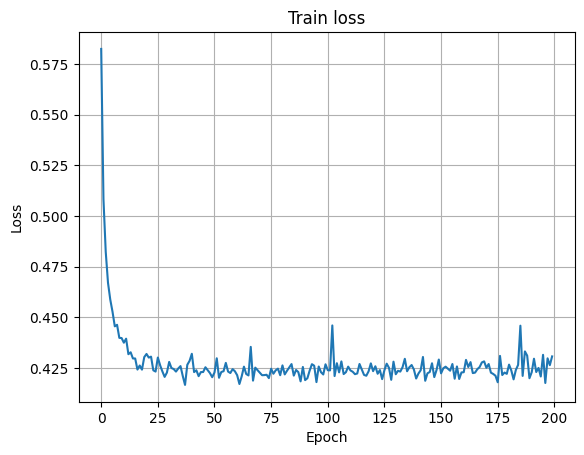

In [126]:
plt.title("Train loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(train_loss_history)

### Validation

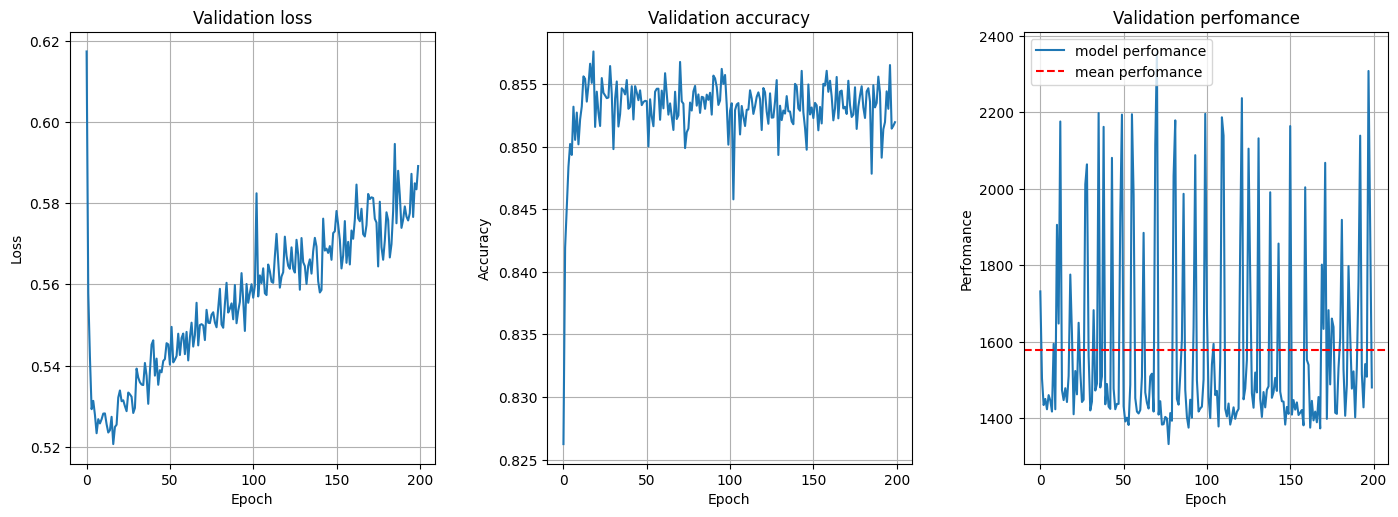

In [127]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.tight_layout(pad=5.0)

plt.subplot(1, 3, 1)
plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.figure(figsize=(10,6))
plt.plot(val_loss_history)


plt.subplot(1, 3, 2)
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
# plt.figure(figsize=(10,6))
plt.plot(val_accuracy_history)

plt.subplot(1, 3, 3)
plt.title("Validation perfomance")
plt.xlabel('Epoch')
plt.ylabel('Perfomance')
plt.grid(True)
# plt.figure(figsize=(10,6))
plt.plot(val_perfomance_history, label='model perfomance')
plt.axhline(y=np.nanmean(val_perfomance_history), color='red', linestyle='--', label='mean perfomance')
plt.legend(loc="upper left")



### График embeddings

In [128]:
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [129]:
df = pd.read_csv("emb.csv")

In [130]:
px.scatter(
    df,
    x='dim_0', y='dim_1',
    text = 'token',
    animation_frame='epoch',
    animation_group='token',
    # size='pop',
    # color='continent',
    hover_name='token'
    # log_x=True,
    # size_max=55,
    # range_x=[100, 100000], range_y=[25, 90]
)

### Результаты лучшей модели на тестовой выборке

In [131]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset


In [132]:
import torch

best_model = SyscallNetwork(
        syscalldataset.token_size,
        len(syscalldataset.syscalls_name),
        hidden_dim_2=hidden_dim_2,
        embedding_dim=embedding_dim,
        max_norm=max_norm,
)

best_model.load_state_dict(torch.load('best-model-syscall-prediction.pt'))
best_model.eval()

SyscallNetwork(
  (embedding): Embedding(5000, 4, padding_idx=0, max_norm=2)
  (linear_1): Linear(in_features=180, out_features=16, bias=True)
  (sigmoid): Sigmoid()
  (linear_2): Linear(in_features=16, out_features=157, bias=True)
)

In [133]:
test_loss, test_accuracy, test_perfomance = compute_loss_accuracy_perfomance(loss_f, best_model, test_dataloader)

In [134]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {int(test_accuracy * 100)}')
print(f'Test perfomance: {test_perfomance}')


Test loss: 0.513826841449404
Test accuracy: 85
Test perfomance: 3653
